## Introduction

We present an analysis of emotions linked to tweets in order to detect instances of cyberbulling.
The tweets dataset has been manually collected using twitter APIs by Margarita Bugueño, Fabián Fernandez and Francisco Mena.

The NRC Emotion Lexicon (aka Emolex) is a list of English words and their associations with eight basic emotions (anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments (negative and positive). It has been developed by [Saif Mohammad](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm) and is a lexic tag based on the Plutchick wheel of emotions. The annotations were manually done by crowdsourcing.


## Exploratory Analysis
To begin this exploratory analysis, first import libraries and define functions for plotting the data using `matplotlib`. Depending on the data, not all plots will be made. (Hey, I'm just a simple kerneling bot, not a Kaggle Competitions Grandmaster!)

In [87]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')


There are 44 csv files in the current version of the dataset:


In [88]:
print(os.listdir('data'))
print(os.listdir('data/tweets'))

['tweets']
['shadical.csv', 'gertrxde.csv', 'amourkaoir.csv', 'doragtz1999.csv', 'LifeSuckSmith.csv', 'saadteengiirl.csv', 'thelife_ofkeke.csv', 'dontstephoverme.csv', 'llaaiikkyynn.csv', 'WieBoth.csv', 'bmarsh2016.csv', 'basicxxcaitlyn.csv', 'itsjustindiaaa.csv', 'TabithaRenea97.csv', '_SamVsTheWorld.csv', 'lonely_dag.csv', 'YungDreez_513.csv', 'Chicatriste_.csv', 'daddyrogo.csv', 'ayolilmami.csv', 'ch8tta.csv', 'steveningersol1.csv', 'thatgirlkanisha.csv', 'parishighlife.csv', 'kbc00per.csv', 'sammay_b.csv', 'parrazserenity.csv', 'IrisNotIrish24.csv', 'caitlinnwells.csv', 'Hayes_502.csv', 'MDinOK.csv', 'CloudyCanine.csv', 'bailee_marie_mc.csv', 'madisonathacker.csv', 'RebekahhJM.csv', 'gayrissa.csv', 'keatsy2112.csv', 'alyssalg93.csv', 'lxrree.csv', 'elizzabethkayy.csv', 'dorsey_5.csv', 'kvenissed.csv', 'Taylor1Savanna.csv']


In [89]:
# Previewing one file alyssalg93.csv 

tweets = pd.read_csv('data/tweets/alyssalg93.csv', delimiter=',')
tweets.dataframeName = 'alyssalg93.csv'
print(f'There are {tweets.shape[0]} rows and {tweets.shape[1]} columns')
tweets.head()

There are 2733 rows and 5 columns


,id,favorite count,retweet count,text,created at
0,897881647458209794,1,0,@GrantCoss_19 Not me! I stop 100X for dance br...,2017-08-16 18:04:01
1,897625970286493696,1,0,@dean_unglert looks bored af during this meeti...,2017-08-16 01:08:03
2,897495687671291908,1,0,@RBlaedow @ShaniaTwain And until they invite B...,2017-08-15 16:30:21
3,895824697220243456,0,0,I never want raven or Paul to be HOH #BB19,2017-08-11 01:50:26
4,895746158022316033,0,0,Dorit Kemsley just liked my comment on Ig. Lif...,2017-08-10 20:38:20


# Using the NRC Emoticon Lexicon
We will be using the NRC Emotion Lexicon for the sentiment analysis of the tweets.
The NRC Emotion Lexicon is a list of English words and their associations with eight basic e motions 
(anger, fear, anticipation, trust, surprise, sadness, joy, and disgust) and two sentiments 
(negative and positive). The annotations were manually done by crowdsourcing.

In [90]:
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from tqdm import tqdm_notebook as tqdm

stemmer = SnowballStemmer("english")


lexicon = "NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
emolex_df = pd.read_csv(lexicon,
                            names=["word", "emotion", "association"],
                            sep='\t')

emolex_df.dropna(subset=['word'], inplace=True)

emolex_words = emolex_df.pivot(index='word',
                                columns='emotion',
                                values='association')

emolex_words.index = emolex_words.index.map(lambda w: stemmer.stem(w.lower()) if w else nan)

emotions = emolex_words.columns.values

emolex_words['emotions'] = list(zip(emolex_words.anger, emolex_words.anticipation, emolex_words.disgust,
                                  emolex_words.fear, emolex_words.joy, emolex_words.negative, emolex_words.positive,
                                   emolex_words.sadness, emolex_words.surprise, emolex_words.trust))

# Convert into a dictionary for faster lookup
emolex_dict = emolex_words['emotions'].to_dict()



print("We built a dictionary of {} words associated to emotions".format(len(emolex_dict)))

We built a dictionary of 10943 words associated to emotions


In [92]:
# Run only once
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/maurizio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [93]:
def text_emotion(df, column):
    '''
    Takes a DataFrame and a specified column of text and adds 10 columns
    for each of the 10 emotions in the NRC Emotion Lexicon, with each
    column containing the value of the text in that emotions and the counts of tweets
    INPUT: DataFrame, string
    OUTPUT: New DataFrame with ten new columns
    '''

    new_df = df.drop(['id', 'favorite count', 'retweet count', 'created at'], axis=1)
    new_df['document'] = pd.Series()
    new_df = new_df.reindex(columns=new_df.columns.tolist())
    # Convert to numpy array
    tweets = new_df.copy().to_numpy()
    scores = np.zeros((tweets.shape[0], len(emotions)))
    #print(scores.shape)


    with tqdm(total=new_df.shape[0]) as pbar:
        for i, text in enumerate(tweets[:, 0]):        
            pbar.update(1)
            #print("Iteration ",i)
            document = word_tokenize(text)
            tweets[i, 2] = document
            for w, word in enumerate(document):
                document[w] = stemmer.stem(word.lower())
                #emo_score = emolex_words[emolex_words.word == word].values
                emo_score = emolex_dict.get(word)
                if emo_score != None:
                    scores[i,:] += list(emo_score)
    
    tweets_df = pd.DataFrame(data=tweets, columns=new_df.columns)
    scores_df = pd.DataFrame(data=scores, columns=emotions)

    return pd.concat([tweets_df, scores_df], axis=1)  

Now we can read all the files and build one dataframe with the emolex scores from all the tweets in the directory

In [94]:
# Read all set of tweets and build sentiment dataframes
df_emo_all = pd.DataFrame()
for file in os.listdir('data/tweets'):  
    df = pd.read_csv('data/tweets/'+file, delimiter=',')
    df['screen_name'] = os.path.splitext(file)[0]
    print("Scoring tweets from ", os.path.splitext(file)[0])
    df_emo = text_emotion(df, 'text')
    df_emo_all = pd.concat([df_emo_all, df_emo])
    
df_emo_all.shape

Scoring tweets from  shadical



Scoring tweets from  gertrxde



Scoring tweets from  amourkaoir



Scoring tweets from  doragtz1999



Scoring tweets from  LifeSuckSmith



Scoring tweets from  saadteengiirl



Scoring tweets from  thelife_ofkeke



Scoring tweets from  dontstephoverme



Scoring tweets from  llaaiikkyynn



Scoring tweets from  WieBoth



Scoring tweets from  bmarsh2016



Scoring tweets from  basicxxcaitlyn



Scoring tweets from  itsjustindiaaa



Scoring tweets from  TabithaRenea97



Scoring tweets from  _SamVsTheWorld



Scoring tweets from  lonely_dag



Scoring tweets from  YungDreez_513



Scoring tweets from  Chicatriste_



Scoring tweets from  daddyrogo



Scoring tweets from  ayolilmami



Scoring tweets from  ch8tta



Scoring tweets from  steveningersol1



Scoring tweets from  thatgirlkanisha



Scoring tweets from  parishighlife



Scoring tweets from  kbc00per



Scoring tweets from  sammay_b



Scoring tweets from  parrazserenity



Scoring tweets from  IrisNotIrish24



Scoring tweets from  caitlinnwells



Scoring tweets from  Hayes_502



Scoring tweets from  MDinOK



Scoring tweets from  CloudyCanine



Scoring tweets from  bailee_marie_mc



Scoring tweets from  madisonathacker



Scoring tweets from  RebekahhJM



Scoring tweets from  gayrissa



Scoring tweets from  keatsy2112



Scoring tweets from  alyssalg93



Scoring tweets from  lxrree



Scoring tweets from  elizzabethkayy



Scoring tweets from  dorsey_5



Scoring tweets from  kvenissed



Scoring tweets from  Taylor1Savanna


(67511, 13)

In [29]:
df_emo_all.head()

,text,screen_name,document,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
0,@GrantCoss_19 Not me! I stop 100X for dance br...,alyssalg93,"[@, grantcoss_19, not, me, !, i, stop, 100x, f...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,@dean_unglert looks bored af during this meeti...,alyssalg93,"[@, dean_unglert, look, bore, af, dure, this, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,@RBlaedow @ShaniaTwain And until they invite B...,alyssalg93,"[@, rblaedow, @, shaniatwain, and, until, they...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I never want raven or Paul to be HOH #BB19,alyssalg93,"[i, never, want, raven, or, paul, to, be, hoh,...",1.0,0.0,0.0,1.0,0.0,2.0,0.0,2.0,0.0,0.0
4,Dorit Kemsley just liked my comment on Ig. Lif...,alyssalg93,"[dorit, kemsley, just, like, my, comment, on, ...",0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [95]:
# Aggregating Grouping data together
df_emotions = df_emo_all.groupby('screen_name')['anger','anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust','negative', 'positive'].mean()
df_emotions['n_tweets']=df_emo_all.screen_name.value_counts()
df_emotions.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_tweets
screen_name,,,,,,,,,,,
Chicatriste_,0.211359,0.153127,0.171819,0.181884,0.300503,0.262401,0.081237,0.303379,0.549245,0.535586,1391
CloudyCanine,0.112257,0.108438,0.068347,0.129439,0.231768,0.139366,0.074456,0.234822,0.296296,0.478427,2619
Hayes_502,0.174223,0.130386,0.124391,0.167478,0.245410,0.211315,0.077557,0.255901,0.498314,0.473586,2669
IrisNotIrish24,0.148305,0.072034,0.078390,0.108051,0.141949,0.182203,0.061441,0.144068,0.447034,0.309322,472
LifeSuckSmith,0.074074,0.092593,0.055556,0.148148,0.166667,0.148148,0.018519,0.259259,0.388889,0.537037,54


## Exploratory Analysis

In [96]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [97]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    #plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()


In [98]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Now you're ready to read in the data and use the plotting functions to visualize the data.

Distribution graphs (histogram/bar graph) of sampled columns:

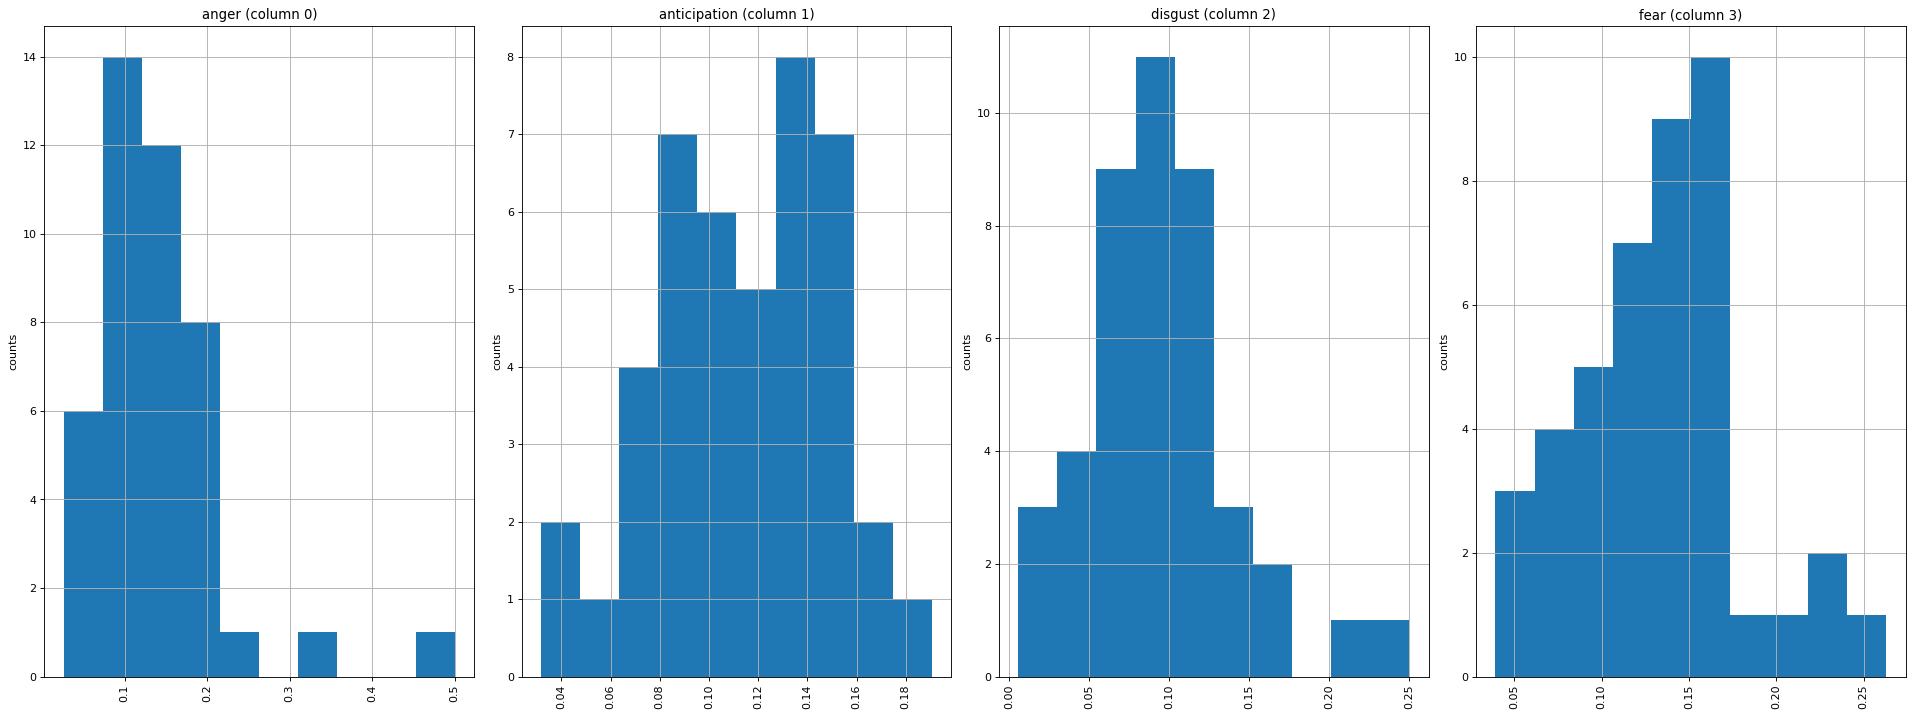

In [99]:
plotPerColumnDistribution(df_emotions.drop(['n_tweets'], axis=1), 4, 4)
#plotPerColumnDistribution(df1, 10, 5)

Correlation matrix:

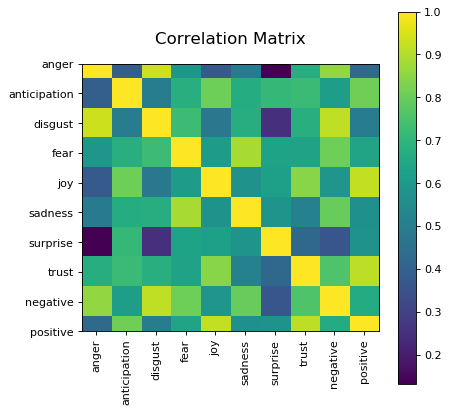

In [100]:
plotCorrelationMatrix(df_emotions.drop(['n_tweets'], axis=1), 6)

Scatter and density plots:

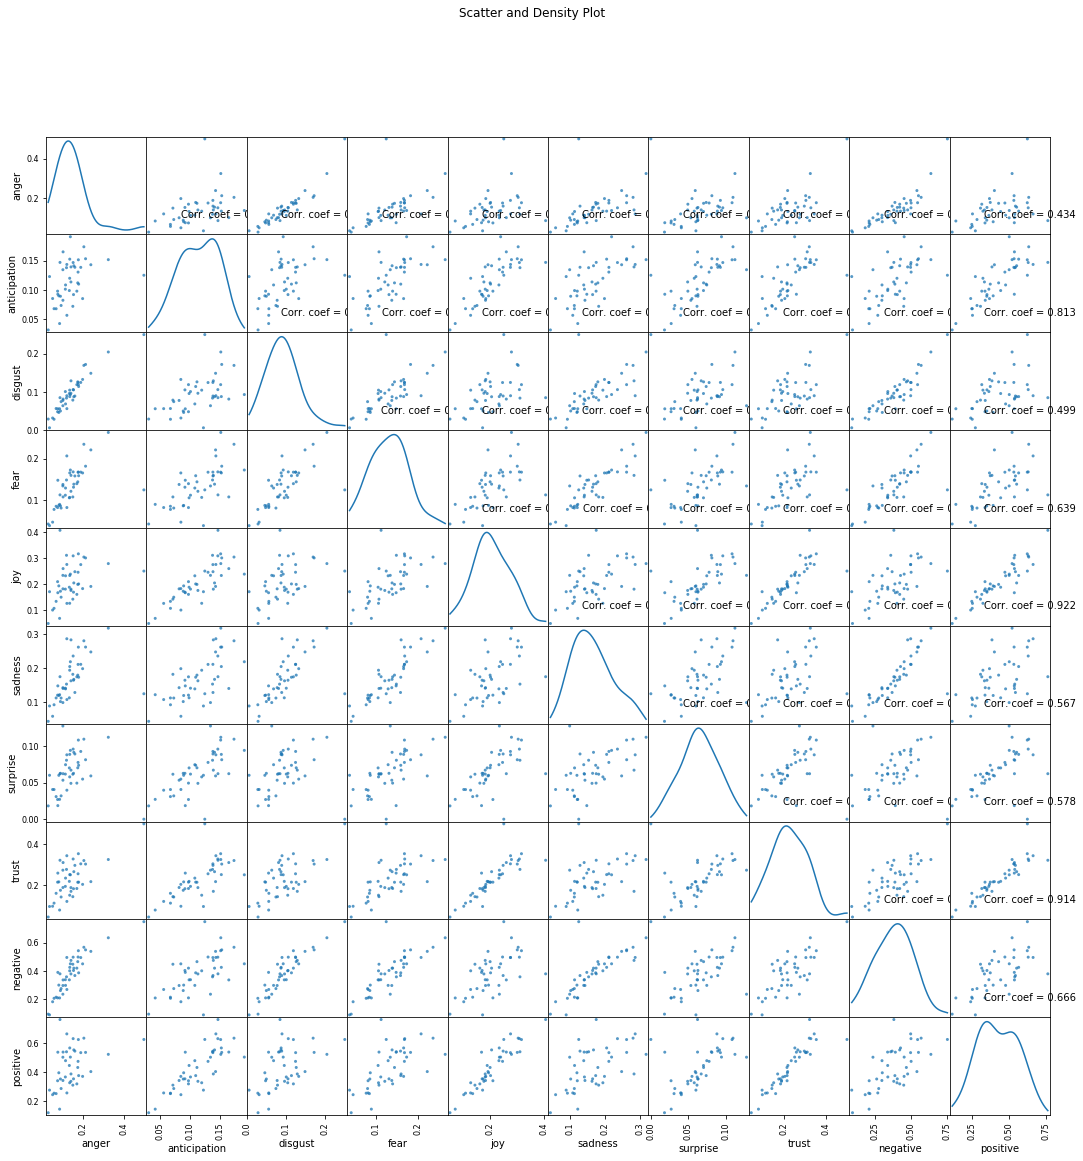

In [101]:
plotScatterMatrix(df_emotions.drop(['n_tweets'], axis=1), 18, 10)

In [102]:
df_emotions.head()

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_tweets
screen_name,,,,,,,,,,,
Chicatriste_,0.211359,0.153127,0.171819,0.181884,0.300503,0.262401,0.081237,0.303379,0.549245,0.535586,1391
CloudyCanine,0.112257,0.108438,0.068347,0.129439,0.231768,0.139366,0.074456,0.234822,0.296296,0.478427,2619
Hayes_502,0.174223,0.130386,0.124391,0.167478,0.245410,0.211315,0.077557,0.255901,0.498314,0.473586,2669
IrisNotIrish24,0.148305,0.072034,0.078390,0.108051,0.141949,0.182203,0.061441,0.144068,0.447034,0.309322,472
LifeSuckSmith,0.074074,0.092593,0.055556,0.148148,0.166667,0.148148,0.018519,0.259259,0.388889,0.537037,54


In [103]:
# How many bullies do we have??

df_emotions[df_emotions.anger > 0.3]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_tweets
screen_name,,,,,,,,,,,
gertrxde,0.323976,0.151585,0.204425,0.26288,0.278732,0.318032,0.111955,0.325627,0.635403,0.522127,3028
saadteengiirl,0.500000,0.125000,0.250000,0.12500,0.250000,0.125000,0.000000,0.500000,0.750000,0.625000,8


In [104]:
# and potentially bullied?
df_emotions[df_emotions.fear > 0.3]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_tweets
screen_name,,,,,,,,,,,


In [105]:
#Top 10 angriest
df_emotions.sort_values(by='anger', ascending=False)[:10]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_tweets
screen_name,,,,,,,,,,,
saadteengiirl,0.500000,0.125000,0.250000,0.125000,0.250000,0.125000,0.000000,0.500000,0.750000,0.625000,8
gertrxde,0.323976,0.151585,0.204425,0.262880,0.278732,0.318032,0.111955,0.325627,0.635403,0.522127,3028
thelife_ofkeke,0.237500,0.142905,0.148649,0.220946,0.190878,0.247973,0.059122,0.217568,0.538514,0.403041,2960
Chicatriste_,0.211359,0.153127,0.171819,0.181884,0.300503,0.262401,0.081237,0.303379,0.549245,0.535586,1391
gayrissa,0.202944,0.173502,0.169295,0.234490,0.303891,0.280757,0.109359,0.320715,0.567823,0.634069,951
doragtz1999,0.196755,0.085193,0.132522,0.165652,0.182556,0.198783,0.054767,0.204192,0.449628,0.369844,1479
sammay_b,0.187576,0.138449,0.124645,0.167682,0.274868,0.211531,0.092570,0.304507,0.494519,0.533902,2463
itsjustindiaaa,0.177089,0.109877,0.113968,0.158971,0.200468,0.173583,0.073641,0.215079,0.385739,0.375219,1711
parrazserenity,0.175676,0.151351,0.118919,0.167568,0.316216,0.262162,0.108108,0.354054,0.543243,0.624324,370


In [106]:
#Top 10 saddest
df_emotions.sort_values(by='sadness', ascending=False)[:10]

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,n_tweets
screen_name,,,,,,,,,,,
gertrxde,0.323976,0.151585,0.204425,0.262880,0.278732,0.318032,0.111955,0.325627,0.635403,0.522127,3028
Taylor1Savanna,0.118547,0.143403,0.089866,0.206501,0.275335,0.286807,0.087954,0.344168,0.495220,0.663480,523
WieBoth,0.139175,0.139175,0.128866,0.159794,0.180412,0.283505,0.067010,0.170103,0.474227,0.386598,194
gayrissa,0.202944,0.173502,0.169295,0.234490,0.303891,0.280757,0.109359,0.320715,0.567823,0.634069,951
Chicatriste_,0.211359,0.153127,0.171819,0.181884,0.300503,0.262401,0.081237,0.303379,0.549245,0.535586,1391
parrazserenity,0.175676,0.151351,0.118919,0.167568,0.316216,0.262162,0.108108,0.354054,0.543243,0.624324,370
thelife_ofkeke,0.237500,0.142905,0.148649,0.220946,0.190878,0.247973,0.059122,0.217568,0.538514,0.403041,2960
RebekahhJM,0.149863,0.146654,0.105866,0.168194,0.308433,0.236022,0.095784,0.328139,0.497250,0.630614,2182
alyssalg93,0.136114,0.190633,0.092938,0.172704,0.238200,0.219173,0.094036,0.251006,0.450055,0.503110,2733


In [107]:
# We could develop a metric to define a "bully" with some tresholds

def is_a_bully(screen_name, df):
    """
    Test function to flag a user as a potential bully using the aggregated metrics
    
    """
    
    
    
    return False

## Conclusion
So where from now? Can you build a predictive model based on tweets?

In [108]:
# Let's play with isiZulu

def build_emolex(language):
        
    lexicon = "NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-v0.92_"+language+".txt"
    emolex_words = pd.read_csv(lexicon,
                            index_col=0,
                            sep='\t', na_values='NO TRANSLATION')
    print(emolex_words.shape)
    #emolex_words.index = emolex_words.index.map(lambda w: stemmer.stem(w.lower()) if w else nan)

    emotions = emolex_words.columns.values
    emolex_words['emotions'] = list(zip(*map(emolex_words.get, emolex_words)))
    # Convert into a dictionary for faster lookup
    emolex_dict = emolex_words['emotions'].to_dict()
    print("We built a dictionary of {} words associated to {} emotions".format(len(emolex_dict), len(emotions)))
    return (emolex_dict, emotions)

In [109]:
language='isizulu'
isizulu = build_emolex('isizulu')

(14182, 10)
We built a dictionary of 8825 words associated to 10 emotions


In [110]:
len(isizulu[1])

10

In [111]:
# define a function to score a sentence
from nltk import word_tokenize
def sentence_emotions(sentence, emo_dict):
    sentence_score = np.zeros(10)
    emolex, emotions = emo_dict
    document = word_tokenize(sentence)
    for w, word in enumerate(document):
                #document[w] = stemmer.stem(word.lower())
                #emo_score = emolex_words[emolex_words.word == word].values
                emo_score = emolex.get(word)
                if emo_score != None:
                    sentence_score += emo_score
    print("Sentence scores:")
    for i in range(len(emotions)):
        print("{}: {}".format(emotions[i],sentence_score[i]))
    return

In [112]:
sentence_emotions("bulala ukudabuka", isizulu)

Sentence scores:
Positive: 0.0
Negative: 2.0
Anger: 1.0
Anticipation: 0.0
Disgust: 0.0
Fear: 0.0
Joy: 0.0
Sadness: 1.0
Surprise: 0.0
Trust: 1.0


In [113]:
language='isizulu'
isizulu = build_emolex('isizulu')

(14182, 10)
We built a dictionary of 8825 words associated to 10 emotions


In [114]:
language='xhosa'
sesotho, emotions = build_emolex(language)

(14182, 10)
We built a dictionary of 8204 words associated to 10 emotions


In [117]:
language='sesotho'
sesotho, emotions = build_emolex(language)

(14182, 10)
We built a dictionary of 8167 words associated to 10 emotions


In [118]:
sesotho.get('ho etsa lichelete')

(0, 1, 0, 0, 0, 0, 0, 0, 0, 1)

In [84]:
language='sesotho'
lexicon = "NRC-Sentiment-Emotion-Lexicons/NRC-Emotion-Lexicon-v0.92/NRC-Emotion-Lexicon-v0.92_"+language+".txt"
emolex_words = pd.read_csv(lexicon,
                            index_col=0,
                            sep='\t')

emolex_words = emolex_words[emolex_words.index!='NO TRANSLATION']

print(emolex_words.shape)
#emolex_words.index = emolex_words.index.map(lambda w: stemmer.stem(w.lower()) if w else nan)

emotions = emolex_words.columns.values
emolex_words['emotions'] = list(zip(*map(emolex_words.get, emolex_words)))
emolex_dict = emolex_words['emotions'].to_dict()
print("We built a dictionary of {} words associated to {} emotions".format(len(emolex_dict), len(emotions)))


(13911, 10)
We built a dictionary of 8166 words associated to 10 emotions


In [86]:
dict_set = set(emolex_words['emotions'].to_dict().keys())
emo_set = set(emolex_words.index)


Index(['back', 'abacus', 'tlohela', 'e tlohetsoe', 'ho lahla', 'khaotsa',
       'ho fokotseha', 'abba', 'Abbot', 'sefubedu',
       ...
       'ba chesehang', 'liqoaha', 'zenith', 'zephyr', 'zeppelin', 'zip',
       'zodiac', 'zoo', 'tsa lintho tse phelang', 'zoology'],
      dtype='object', name='Sesotho (st)', length=8166)

In [ ]:
# Can you write a scoring function using bi-grams (a sequence of two words) and tri-grams (a sequence of three words)




In [ ]:
# Build a dictionary that works for "Joburg Zulu" by mixing english and zulu words
# and adding slang
